# 2022 데이터 크리에이터 캠프 예선 (2022. 11. 04.)

### 1. 구글 드라이브 마운트 및 전체 분석 모듈 준비

In [ ]:
# 코랩 GPU 사용을 위한 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-addons                                     # tfa import 오류 대응을 위한 pip install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
# 세부 목적별 라이브러리 임포트

# 기본 라이브러리
import os                                                           # 작업 디렉토리 확인 및 접근
import glob                                                         # 서브 디렉토리 접근
import csv                                                          # csv 파일 읽고 쓰기
import numpy as np                                                  # numpy array(ndarray) 구조 사용 및 조작
import pandas as pd                                                 # Dataframe, Series 구조 사용 및 조작
import matplotlib.pyplot as plt                                     # 분석 과정, 결과 시각화


# 이미지 데이터 전처리 및 가공
import cv2                                                          # 이미지 처리를 위한 핵심 라이브러리 1 (- BGR - 컬러스페이스)
from PIL import Image                                               # 이미지 처리를 위한 핵심 라이브러리 2 (- RGB - 컬러스페이스)
from sklearn.preprocessing import MinMaxScaler                      # 0 ~ 255의 RGB 값을 0 ~ 1의 범위 이내로 변경
import re                                                           # 정규표현식 사용
import imblearn                                                     # 데이터 언더샘플링
from google.colab.patches import cv2_imshow                         # 이미지 시각화
from numpy import unique                                            # 특정 열의 고유값 출력
import random                                                       # 무작위 난수 생성


# 이미지 클러스터링
from sklearn.cluster import KMeans                                  # K-means Clustering (K-평균 군집화)
from sklearn.cluster import AgglomerativeClustering                 # Agglomerative Clustering (계층적 군집화 - 병합 군집)

# 분석 모형 준비
import tensorflow as tf                                             # keras 기반 이미지분류 수행을 위한 핵심 라이브러리
import tensorflow_addons as tfa                                     # keras 기반 이미지분류 수행을 위한 핵심 라이브러리 (!pip install 필요)
from tensorflow import keras                                        # keras 기반 이미지분류 수행을 위한 핵심 라이브러리
from tensorflow.keras.models import load_model                                        

from sklearn.model_selection import train_test_split                # Train Set과 Test(Validation) Set 구분
from sklearn.model_selection import StratifiedKFold                 # K-fold Cross Validation 적용

# 분석 모형 적용
from tensorflow.keras import Model, Input                           # keras 기반 모형과 입력층을 제시하는 모듈
from tensorflow.keras import layers                                 # keras 기반 은닉층과 출력층 설계를 위한 모듈

from keras.preprocessing.image import ImageDataGenerator            # 학습 성과 개선을 위한 Image Augementation 기법 적용
from tensorflow.keras.layers.experimental import preprocessing      # 학습 성과 개선을 위한 이미지 전처리 기법 적용

from keras.models import load_model                                 # 외부 모델 로드
from keras.models import Sequential                                 # 입력층부터 출력층까지 선형으로 연결된 순차 모형 구조 선언

from keras.layers import Convolution2D, MaxPooling2D                # 합성곱 주요 신경망 1 - Convolution 2D 레이어, MaxPooling 2D 레이어 선언
from keras.layers import ZeroPadding2D, GlobalAveragePooling2D      # 합성곱 주요 신경망 2 - Zero Padding 2D 레이어, Global Average Pooling 2D 레이어 선언
from keras.layers import Activation, Dropout, Flatten, Dense, Add   # 활성화 함수, 드롭아웃, 평탄화 층 선언

from keras import optimizers, initializers, regularizers, metrics   # 옵티마이저, 평가 메트릭 등 하이퍼파라미터 관련 요소
from sklearn.metrics import f1_score, classification_report         # F1-score 포함 보고 및 평가 지표
from keras.callbacks import EarlyStopping, ReduceLROnPlateau        # 모델에 조기 종료와 학습률 조정을 위한 콜백 함수 포함
from keras.callbacks import ModelCheckpoint                         # 최고 성과를 낸 모델의 저장을 위한 체크포인트 설정

# 기타 라이브러리
import warnings                                                     # 분석에 지장 없는 경고 무시
from collections import Counter                                     # 범주별 빈도 수 차이에 따른 가중치 부여를 위해 사용
import shutil                                                       # valid set 복사하여 f1 score 산출에 사용
from sklearn.metrics import f1_score, classification_report         # f1 score 산출에 사용                                              

In [ ]:
# 데이터셋이 있는 상위 폴더의 경로 지정

os.getcwd()
os.chdir("/content/drive/MyDrive/데이터셋2")

### 2. 데이터 준비

In [ ]:
### 작업에 약간 시간이 걸림 주의 ###

# 이미지가 포함된 경로를 리턴하는 반복문
# 하위 디렉토리가 잡힐 경우 재실행하기 위해 함수 형태로 선언, if __name__ == "__main__" 구문 포함

path_list = []

def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file)                         # 경로 리턴
        if os.path.isdir(path):                                     # 파일이 아니라 디렉토리인 경우
            print_files_in_dir(path, prefix + "    ")               # 하위 파일에 대해 재실행(접두사 포함)
        else:
          ext = os.path.splitext(path)[-1]                          # 파일 이름, 확장자 분리
          path_list.append(path)                                    # 위 확장자 파일인 경우 list에 추가

if __name__ == "__main__":
    root_dir = "./데이터셋/"     ### 상위 폴더의 경로를 지정하면 모든 하위 폴더에 포함된 이미지 파일의 경로가 저장됨.
    print_files_in_dir(root_dir, "")

In [ ]:
# 정규표현식을 활용해 서브 디렉토리의 폴더 이름을 class로 정의하여 리턴

totaldata = pd.DataFrame(path_list, columns = ["path"])
totaldata['label'] = totaldata['path'].str.extract('(L2_\d{0,2})')

In [ ]:
totaldata

,path,label
0,./데이터셋/L2_41/vfzqksomcfjvspabmclc.png,L2_41
1,./데이터셋/L2_41/womfdudxhqthumofgzlr.jpg,L2_41
2,./데이터셋/L2_41/yawshjamksrsswvajcem.jpg,L2_41
3,./데이터셋/L2_41/chajniaghjmocogdkakg.jpg,L2_41
4,./데이터셋/L2_41/xflugmipnrbyszykvuoz.png,L2_41
...,...,...
25498,./데이터셋/L2_27/kizxobgzghyfdpxxgryk.png,L2_27
25499,./데이터셋/L2_27/rjmpijiipfewfevudyil.jpg,L2_27
25500,./데이터셋/L2_27/pihfuerbegvcmnqorgkm.jpg,L2_27
25501,./데이터셋/L2_27/iaqltjyzyznpzbaovdvw.jpg,L2_27


In [ ]:
# totaldata.to_csv("totaldata.csv")
# totaldata = pd.read_csv("totaldata.csv")

### 3. 탐색적 데이터 분석 (Exploratory Data Analysis, EDA)

데이터 생성 방식, 범주별 분포 등 폭넓게 확인할 것



#### 분석 절차

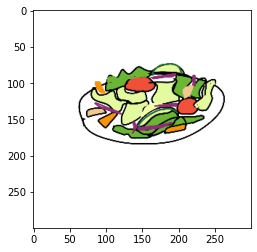

In [ ]:
# 이미지 파일이 잘 불러와지는지 확인

image1 = plt.imread(totaldata.loc[0,'path'])
plt.imshow(image1)

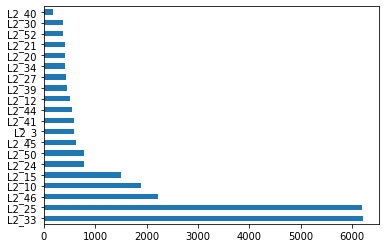

In [ ]:
# 범주별 이미지 파일 갯수를 확인하여 그래프로 제시

totaldata['label'].value_counts().plot(kind='barh')

In [ ]:
# 범주별 이미지 파일 갯수를 확인하여 표료 제시

label_list = totaldata['label'].unique()
total = len(totaldata)

for c in label_list:
	n_cat = len(totaldata[totaldata['label'] == c])
	percent = n_cat / total * 100
	print('> Label = %s : %d/%d (%.1f%%)' % (c, n_cat, total, percent))

> Label = L2_41 : 593/25503 (2.3%)
> Label = L2_46 : 2214/25503 (8.7%)
> Label = L2_3 : 595/25503 (2.3%)
> Label = L2_25 : 6189/25503 (24.3%)
> Label = L2_52 : 382/25503 (1.5%)
> Label = L2_30 : 364/25503 (1.4%)
> Label = L2_39 : 454/25503 (1.8%)
> Label = L2_15 : 1509/25503 (5.9%)
> Label = L2_24 : 782/25503 (3.1%)
> Label = L2_12 : 518/25503 (2.0%)
> Label = L2_10 : 1893/25503 (7.4%)
> Label = L2_20 : 410/25503 (1.6%)
> Label = L2_45 : 631/25503 (2.5%)
> Label = L2_34 : 419/25503 (1.6%)
> Label = L2_21 : 410/25503 (1.6%)
> Label = L2_44 : 547/25503 (2.1%)
> Label = L2_50 : 781/25503 (3.1%)
> Label = L2_33 : 6206/25503 (24.3%)
> Label = L2_40 : 180/25503 (0.7%)
> Label = L2_27 : 426/25503 (1.7%)


In [ ]:
# 범주별 이미지 파일 갯수를 확장자(jpg, png) 별로 구분하여 표로 제시

extension = pd.DataFrame()

for idx, i in enumerate(label_list) :
  result = pd.DataFrame({
      'label' : [i],
      'total' : sum(totaldata['label'] == i),
      'jpg'   : totaldata[totaldata['label'] == i]['path'].str.endswith('.jpg').sum(),
      'png'   : totaldata[totaldata['label'] == i]['path'].str.endswith('.png').sum()
  })
  extension = pd.concat([extension, result], axis = 0)

extension.set_index('label')

,total,jpg,png
label,,,
L2_41,593,554,39
L2_46,2214,2143,71
L2_3,595,558,37
L2_25,6189,6106,83
L2_52,382,299,83
L2_30,364,292,72
L2_39,454,354,100
L2_15,1509,1449,60
L2_24,782,694,88


데이터 불균형 문제 확인 (max : 6206 / min : 180)

두 표의 범주별 총합이 동일하므로 jpg, png 이외 확장자 파일은 존재하지 않는다.

In [ ]:
### 작업에 약간 시간이 걸림 주의 ###

# 범주별 이미지 10개씩 확인하기

for idx, i in enumerate(label_list):                                  # 전체 범주에 대해 반복
  plt.figure(figsize=(16,12))                                         # plot에 표시될 사이즈는 가로 16, 세로 12로 고정
  L2 = totaldata[totaldata['label'] == i]['path']                     # 범주별 파일 경로를 리턴하여 L2에 저장
  print('label =', i)                                                 # plot별 이미지가 속한 범주 출력
  
  for idx2, j in enumerate(L2.sample(20, random_state = 1234)) :      # L2 중 1234번 시드에 따른 무작위 20개 파일 경로 추출
    plt.subplot(10, 10, idx2 + 1)                                     # 가로 10개, 세로 10개의 subplot 공간 확보
    img = plt.imread(j)                                               # 무작위 추출된 파일 경로에 해당하는 이미지 불러오기
    plt.imshow(img)                                                   # 불러온 이미지를 plot에 출력
    plt.axis('off')                                                   # 이미지이므로 x축, y축은 표시되지 않도록 설정
  
  plt.tight_layout()                                                  # plot의 여백은 기본값으로 조정
  plt.show()                                                          # subplot으로 구성된 전체 plot 출력

  print('--------------------------------')                           # 범주별 구분선

label = L2_41


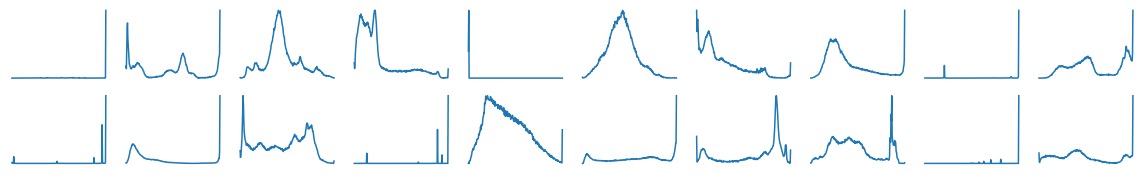

--------------------------------
label = L2_46


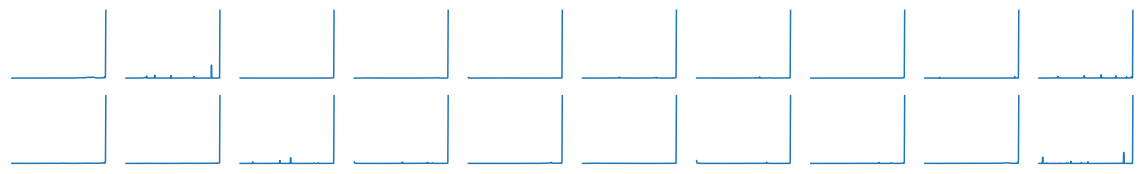

--------------------------------
label = L2_3


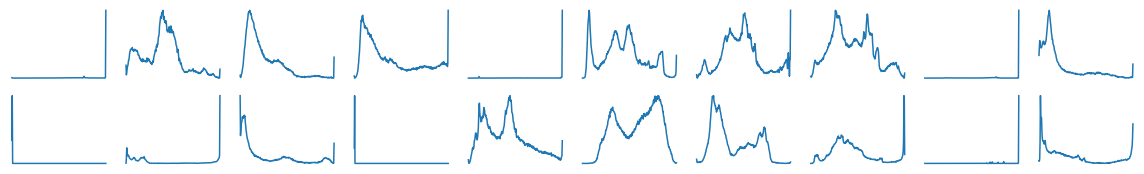

--------------------------------
label = L2_25


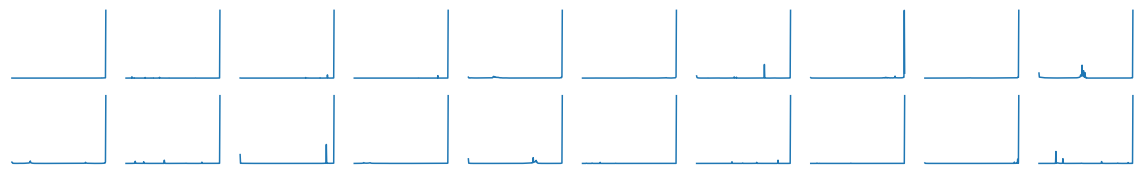

--------------------------------
label = L2_52


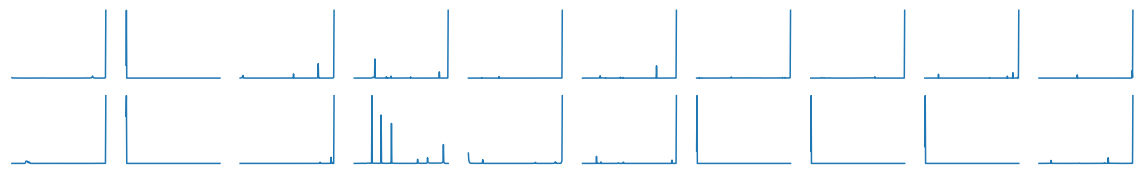

--------------------------------
label = L2_30


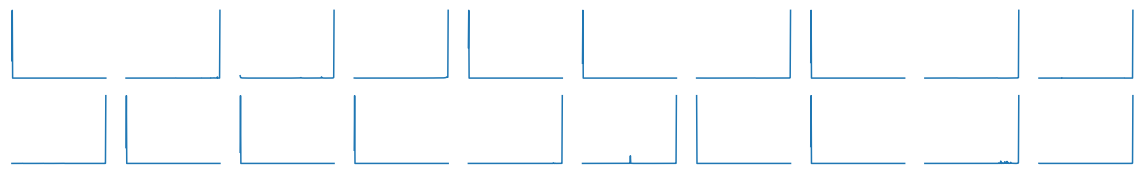

--------------------------------
label = L2_39


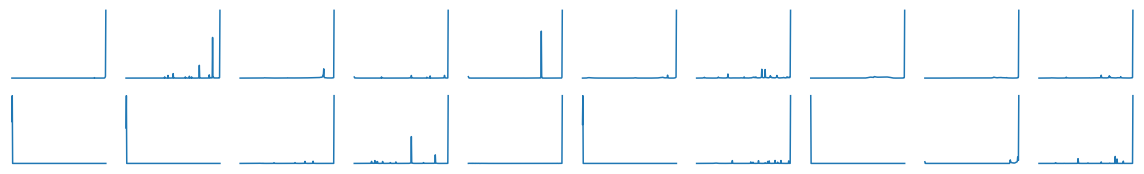

--------------------------------
label = L2_15


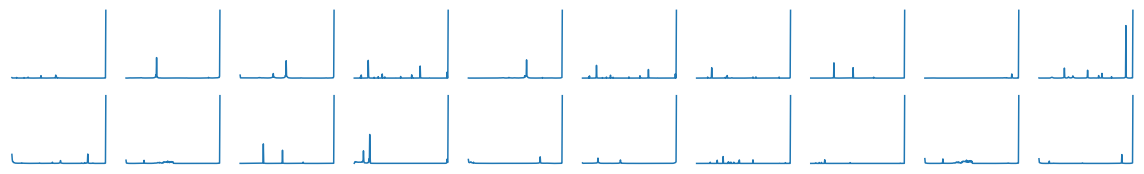

--------------------------------
label = L2_24


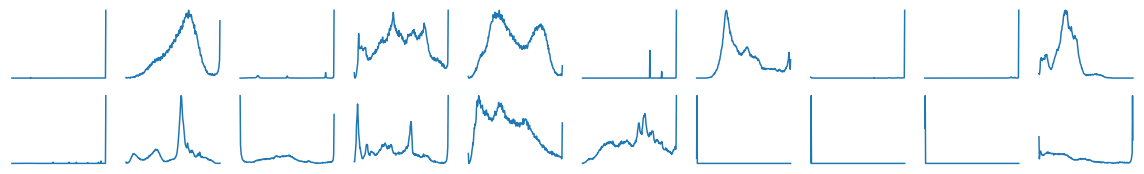

--------------------------------
label = L2_12


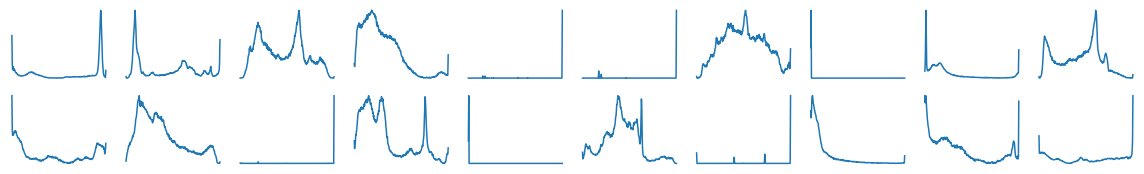

--------------------------------
label = L2_10


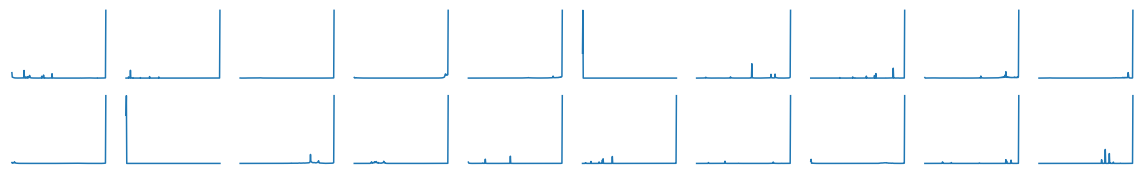

--------------------------------
label = L2_20


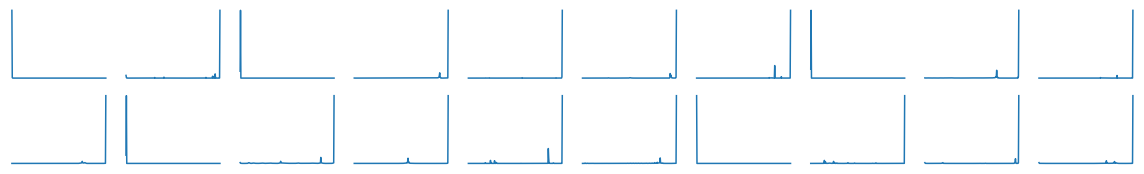

--------------------------------
label = L2_45


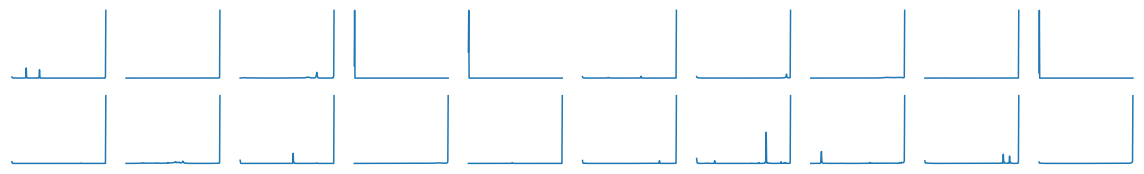

--------------------------------
label = L2_34


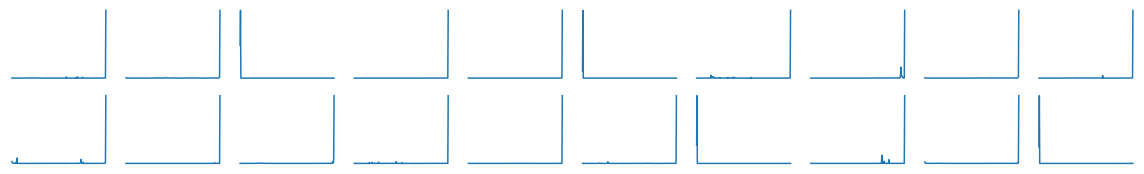

--------------------------------
label = L2_21


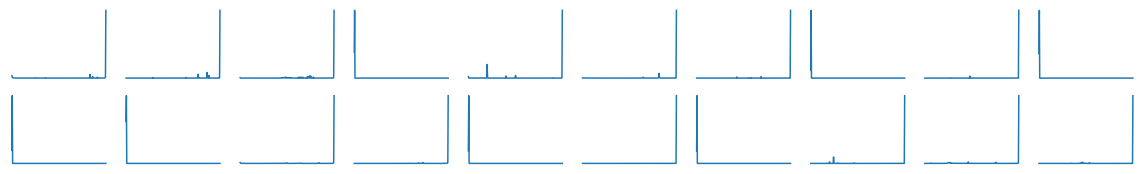

--------------------------------
label = L2_44


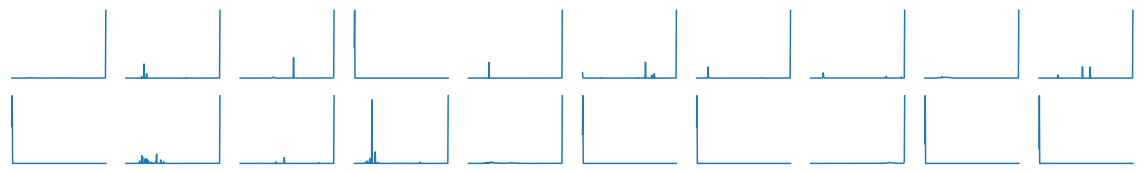

--------------------------------
label = L2_50


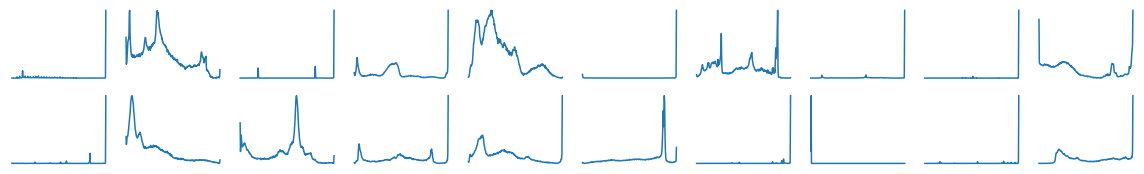

--------------------------------
label = L2_33


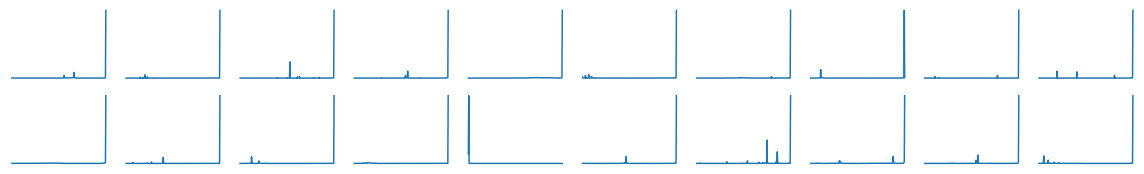

--------------------------------
label = L2_40


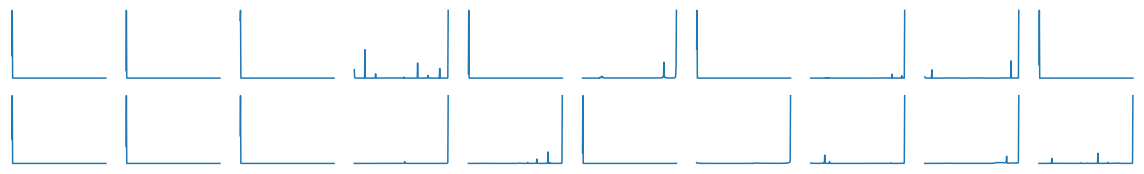

--------------------------------
label = L2_27


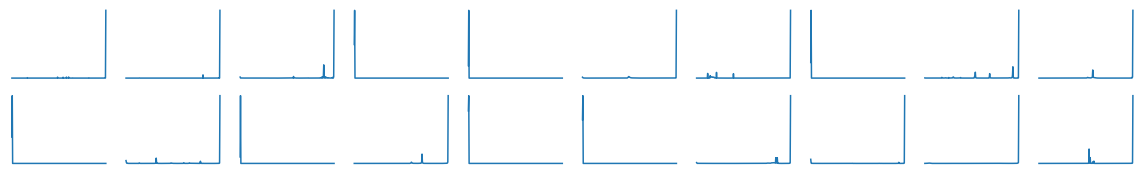

--------------------------------


In [ ]:
### 작업에 약간 시간이 걸림 주의 ###

# 범주별 이미지 밝기 10개씩 확인하기

for idx, i in enumerate(label_list):                                  # 전체 범주에 대해 반복
  plt.figure(figsize=(16,12))                                         # plot에 표시될 사이즈는 가로 16, 세로 12로 고정
  L2 = totaldata[totaldata['label'] == i]['path']                     # 범주별 파일 경로를 리턴하여 L2에 저장
  print('label =', i)                                                 # plot별 이미지가 속한 범주 출력

  for idx2, j in enumerate(L2.sample(20, random_state = 1234)) :      # L2 중 1234번 시드에 따른 무작위 20개 파일 경로 추출
    plt.subplot(10, 10, idx2 + 1)                                     # 가로 10개, 세로 10개의 subplot 공간 확보
    img = plt.imread(j)                                               # 무작위 추출된 파일 경로에 해당하는 이미지 불러오기
    hist = cv2.calcHist([img],[0],None,[256],[0,256])                 # 불러온 이미지의 픽셀 별 밝기의 빈도를 히스토그램으로 전환
    plt.plot(hist)                                                    # 전환된 히스토그램 출력
    plt.axis('off')                                                   # 이미지이므로 x축, y축은 표시되지 않도록 설정
  
  plt.tight_layout()                                                  # plot의 여백은 기본값으로 조정
  plt.show()                                                          # subplot으로 구성된 전체 plot 출력
  
  print('--------------------------------')                           # 범주별 구분선

일러스트 이외의 사진 파일 존재 확인

L2_3, L2_12, L2_24, L2_41, L2_50 5개 범주에서 사진이 제거되어야 함.

label = L2_41 작업 완료
label = L2_46 작업 완료
label = L2_3 작업 완료
label = L2_25 작업 완료
label = L2_52 작업 완료
label = L2_30 작업 완료
label = L2_39 작업 완료
label = L2_15 작업 완료
label = L2_24 작업 완료
label = L2_12 작업 완료
label = L2_10 작업 완료
label = L2_20 작업 완료
label = L2_45 작업 완료
label = L2_34 작업 완료
label = L2_21 작업 완료
label = L2_44 작업 완료
label = L2_50 작업 완료
label = L2_33 작업 완료
label = L2_40 작업 완료
label = L2_27 작업 완료


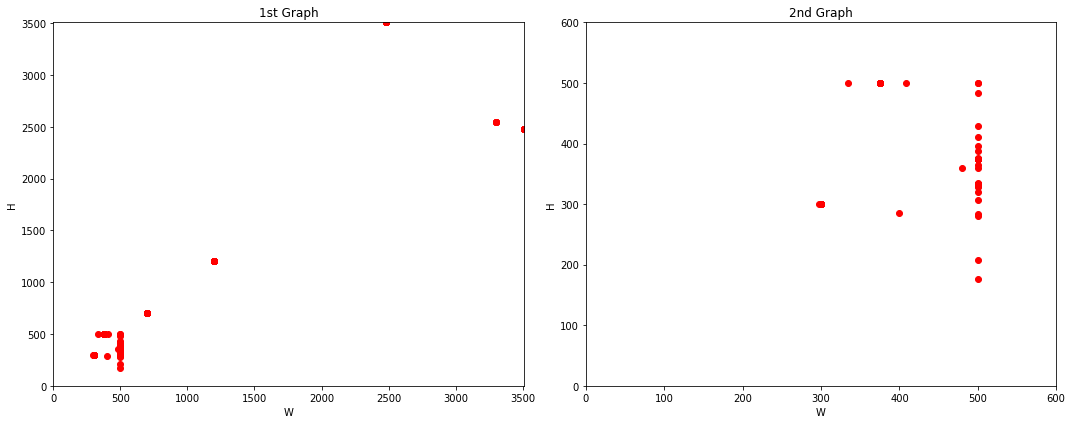

In [ ]:
### 작업에 약간 시간이 걸림 주의 ###

# 이미지 사이즈를 Plot으로 나타내기

arr = np.array([])

for idx, i in enumerate(label_list) :

  for idx2, j in enumerate(totaldata[totaldata['label'] == i]['path'].sample(30, random_state = 1234)) :
    image = cv2.imread(j)
    size = image.shape[:2]
    arr = np.append(arr, np.array(size))
  
  print('label =', i, "작업 완료")

plt.figure(figsize=(15, 6)) 

plt.subplot(1, 2, 1)               # nrows=2, ncols=1, index=1
plt.plot(arr[1::2], arr[0::2] , 'ro')
plt.axis([0, np.max(arr[0::2]), 0, np.max(arr[1::2])])
plt.title('1st Graph')
plt.xlabel('W')
plt.ylabel('H')

plt.subplot(1, 2, 2)                # nrows=2, ncols=1, index=2
plt.plot(arr[1::2] ,arr[0::2] , 'ro')
plt.axis([0, 600, 0, 600])
plt.title('2nd Graph')
plt.xlabel('W')
plt.ylabel('H')

plt.tight_layout()
plt.show()

이미지별 사이즈에 차이가 심함. 분석을 위해 (224, 224) 사이즈로 일괄 통합할 필요가 있음.

### 4. 사진 제거

사진과 일러스트의 제거를 위해 실시함.

비교 결과 Agglomerative Clustering이 K-means Clustering보다 사진과 일러스트를 정확하게 군집화함.

#### 참고자료

K-평균 군집화는 데이터의 정규화 여부에 따라 군집화가 다르게 이루어짐

Visalakshi, N. K., & Thangavel, K. (2009). Distributed data clustering: A comparative analysis. In Foundations of Computational, IntelligenceVolume 6 (pp. 371-397). Springer, Berlin, Heidelberg.

RGB 클러스터링보다 HLS 클러스터링 결과가 더 좋음.

Jurio, A., Pagola, M., Galar, M., Lopez-Molina, C., & Paternain, D. (2010, June). A comparison study of different color spaces in clustering based image segmentation. In International conference on information processing and management of uncertainty in knowledge-based systems (pp. 532-541). Springer, Berlin, Heidelberg.

#### 분석 코드

In [ ]:
condition = totaldata['label'].isin(['L2_3', 'L2_12', 'L2_24', 'L2_41', 'L2_50'])
forcluster_data = totaldata.loc[condition]

In [ ]:
### 작업에 상당한 시간이 걸림 주의 ###

# EDA에서 식별한 사진 제거가 필요한 클래스를 Numpy Array 형태로 불러오기
# 데이터프레임 형태로 선언할 때보다 딕셔너리 형태에서 처리 속도가 빠름.

label_list_c = list(set(forcluster_data['label']))

images2 = {}

for i, dir in enumerate(label_list_c):                              # 5개 범주에 대해 반복
  files = os.listdir("./데이터셋/" + dir)                                    # 5개 범주에 해당하는 하위 폴더에 속한 모든 파일의 경로 리턴
  images = []                                                       # 아래 반복문을 위해 images 초기화
  
  for j, file in enumerate(files):                                  # 5개 범주별 폴더에 속한 개별 파일에 대해 반복
    img = Image.open("./데이터셋/" + dir + "/" + file)                       # 개별 파일의 경로를 통해 이미지 파일 열기
    img = img.convert("RGB")                                        # 모든 jpg와 png 파일의 컬러 채널을 RGB로 변경
    img = img.resize((224, 224))                                    # 이후 분석을 위해 모든 이미지 (224, 224)로 리사이징
    imgs = np.asarray(img)                                          # 이후 분석을 위해 결과를 Array 형태로 변경
    images.append(imgs)                                             # 결과를 images에 통합

  images = np.array(images)                                         # 정확한 결과를 위해 전체 데이터를 다시 Array로 변경
  images2[dir] = images                                             # L2_3 ~ L2_50을 Key로, 범주별 Array를 Value로 갖는 딕셔너리 선언
  print(dir)                                                        # 반복문 진행 과정을 확인하기 위한 enumerate(classname) 리턴
  print(images2[dir].shape)

# 폴더 범주별로 Numpy Array 형태 확인 (폴더 내 파일 갯수, 가로, 세로, 채널(RGB))
# L2_3 : 595 / L2_12 : 518 / L2_24 : 782 / L2_41 : 593 / L2_50 : 781

L2_41
(593, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


L2_24
(782, 224, 224, 3)
L2_50
(781, 224, 224, 3)
L2_3
(595, 224, 224, 3)
L2_12
(518, 224, 224, 3)


위의 EDA 결과와 파일 갯수가 동일하므로 누락된 파일은 없음.

In [ ]:
# Cluster된 개별 범주별 Plot을 그리는 함수

def draw_sample_data(arr, ratio=1):
    n = len(arr)  
    print(n)
    rows = int(np.ceil(n / 10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                            figsize=(cols * ratio, rows * ratio), 
                            squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i * 10 + j < n:
                axs[i, j].imshow(arr[i * 10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

In [ ]:
##RGB기반 딕셔너리

cluster_data = {}
RGB = images2['L2_50'][0, : , : , : ].reshape(1, -1)                            # 위에서 설정한 구조를 Array로 변환

for k, j in enumerate(label_list_c):                                            # 클러스터링이 필요한 5개 범주에 대해 반복
  eachdata = np.array(RGB)                                              

  for idx, i in enumerate(images2[j]):                                                                       
    hist = i.reshape(1,-1)                                                      
    eachdata = np.concatenate((eachdata, hist), axis=0)                         # 결과를 eachdata에 통합
    
  cluster_data[j] = eachdata[1:,:]                                              # 구조를 위해 불러온 첫번째 데이터 제외

In [ ]:
### 작업에 상당한 시간이 걸림 주의 ###

# KMeans 수행(RGB)

RGB_result = []

for i in label_list_c :
  km = KMeans(n_clusters=2, random_state=42) 
  clustering = km.fit(cluster_data[i])   # hclust 클래스 2개가 디폴트
  RGB_result.append(clustering.labels_)

In [ ]:
# ### 작업에 약간 시간이 걸림 주의 ###

# # 클러스터링한 결과들 그림 보기

for idx, i in enumerate(label_list_c):
  print(i)
  draw_sample_data(images2[i][RGB_result[idx] == 0])
  draw_sample_data(images2[i][RGB_result[idx] == 1])

RGB 값으로 K means 한 결과 좋지 않음 -> 계층적 군집으로 수행

In [ ]:
### 작업에 상당한 시간이 걸림 주의 ###

# AgglomerativeClustering 수행(RGB)

RGB_result_H = []

for i in label_list_c :
  clustering = AgglomerativeClustering(linkage = 'ward').fit(cluster_data[i])   # hclust 클래스 2개가 디폴트
  RGB_result_H.append(clustering.labels_)                                       

In [ ]:
# ### 작업에 약간 시간이 걸림 주의 ###

# # 클러스터링한 결과들 그림 보기

for idx, i in enumerate(label_list_c):
 print(i)
 draw_sample_data(images2[i][RGB_result_H[idx] == 0])
 draw_sample_data(images2[i][RGB_result_H[idx] == 1])

K means 보다는 계층적 군집이 수행이 좋음

In [ ]:
# HSV 기반 클러스터링을 위해 RGB -> BGR -> HSV 순으로 순차 변환

cluster_data = {}
RGB_BGR_str = cv2.cvtColor(images2['L2_50'][0, : , : , : ], cv2.COLOR_RGB2BGR)  # Array의 구조를 확보하기 위해 첫번째 데이터만 불러옴.
BGR_HLS_str = cv2.cvtColor(RGB_BGR_str, cv2.COLOR_BGR2HSV).reshape(1, -1)       # 불러온 데이터의 구조를 HSV로 변경

for k, j in enumerate(label_list_c):                                            # 클러스터링이 필요한 5개 범주에 대해 반복
  eachdata = np.array(BGR_HLS_str)                                              # 위에서 설정한 구조를 Array로 변환

  for idx, i in enumerate(images2[j]):                                          # image2의 개별 Key(L2_3 ~ L2_50)의 Value에 대해 반복
    hist = cv2.cvtColor(i,    cv2.COLOR_RGB2BGR)                                # 개별 Array의 컬러 채널을 RGB에서 BGR로 변경
    hist = cv2.cvtColor(hist, cv2.COLOR_BGR2HSV).reshape(1,-1)                  # 개별 Array의 컬러 채널을 BGR에서 HSV로 변경
    eachdata = np.concatenate((eachdata, hist), axis=0)                         # 결과를 eachdata에 통합
    
  cluster_data[j] = eachdata[1:,:]                                              # 구조를 위해 불러온 첫번째 데이터 제외

In [ ]:
### 작업에 상당한 시간이 걸림 주의 ###

# AgglomerativeClustering 수행(HSV)

HSV_result = []

for i in label_list_c :
  clustering = AgglomerativeClustering(linkage = 'ward').fit(cluster_data[i])   # hclust 클래스 2개가 디폴트
  HSV_result.append(clustering.labels_)

In [ ]:
# ### 작업에 약간 시간이 걸림 주의 ###

# # 클러스터링한 결과들 그림 보기

for idx, i in enumerate(label_list_c):
 print(i)
 draw_sample_data(images2[i][HSV_result[idx] == 0])
 draw_sample_data(images2[i][HSV_result[idx] == 1])

RGB 보다 HSV에서 더 좋은 성능을 보임

In [ ]:
# HLS 기반 클러스터링을 위해 RGB -> BGR -> HLS 순으로 순차 변환

cluster_data = {}
RGB_BGR_str = cv2.cvtColor(images2['L2_50'][0, : , : , : ], cv2.COLOR_RGB2BGR)  # Array의 구조를 확보하기 위해 첫번째 데이터만 불러옴.
BGR_HLS_str = cv2.cvtColor(RGB_BGR_str, cv2.COLOR_BGR2HLS).reshape(1, -1)       # 불러온 데이터의 구조를 HLS로 변경

for k, j in enumerate(label_list_c):                                            # 클러스터링이 필요한 5개 범주에 대해 반복
  eachdata = np.array(BGR_HLS_str)                                              # 위에서 설정한 구조를 Array로 변환

  for idx, i in enumerate(images2[j]):                                          # image2의 개별 Key(L2_3 ~ L2_50)의 Value에 대해 반복
    hist = cv2.cvtColor(i,    cv2.COLOR_RGB2BGR)                                # 개별 Array의 컬러 채널을 RGB에서 BGR로 변경
    hist = cv2.cvtColor(hist, cv2.COLOR_BGR2HLS).reshape(1,-1)                  # 개별 Array의 컬러 채널을 BGR에서 HLS로 변경
    eachdata = np.concatenate((eachdata, hist), axis=0)                         # 결과를 eachdata에 통합
    
  cluster_data[j] = eachdata[1:,:]                                              # 구조를 위해 불러온 첫번째 데이터 제외

In [ ]:
### 작업에 상당한 시간이 걸림 주의 ###

# 두 클러스터로 구분된 인덱스를 리스트 형태로 변환

HLS_result = []

for i in label_list_c :
  clustering = AgglomerativeClustering(linkage = 'ward').fit(cluster_data[i])   # hclust 클래스 2개가 디폴트
  HLS_result.append(clustering.labels_)

In [ ]:
# ### 작업에 약간 시간이 걸림 주의 ###

# # 클러스터링한 결과들 그림 보기 / 보수적인 100%

for idx, i in enumerate(label_list_c):
 print(i)
 draw_sample_data(images2[i][HLS_result[idx] == 0])
 draw_sample_data(images2[i][HLS_result[idx] == 1])

계층적 군집으로 HLS상에서 수행한 결과가 제일 좋음

In [ ]:
# 기존의 데이터프레임에서 클러스터링 대상 범주를 클러스터링된 데이터로 교체

clustered_data = pd.DataFrame()
totaldata.drop(totaldata[totaldata['label'].isin(['L2_3', 'L2_12', 'L2_24', 'L2_41', 'L2_50'])].index, inplace = True)

for idx, i in enumerate(label_list_c) :
  include = forcluster_data[forcluster_data['label'] == i][HLS_result[idx] == 1]
  clustered_data = pd.concat([clustered_data, include], axis = 0)

In [ ]:
finaldata = pd.concat([totaldata, clustered_data], axis = 0)

In [ ]:
# 결과 확인

finaldata

,path,label
593,./데이터셋/L2_46/yqzymdxadhipidukphhu.jpg,L2_46
594,./데이터셋/L2_46/eablkuqkenelfbclftjl.jpg,L2_46
595,./데이터셋/L2_46/rhafiwrvyffpqndswnkx.jpg,L2_46
596,./데이터셋/L2_46/rmutoezfmwypatheodhb.jpg,L2_46
597,./데이터셋/L2_46/xnqdrbhrkhshgqchkkry.jpg,L2_46
...,...,...
13199,./데이터셋/L2_12/vvgkndmyazepytjnjkel.jpg,L2_12
13200,./데이터셋/L2_12/bmsntulwsrutggtgkinn.jpg,L2_12
13201,./데이터셋/L2_12/kehvcyooenbjscxngggf.jpg,L2_12
13202,./데이터셋/L2_12/dysytdmmmhypfmkwfbuu.png,L2_12


In [ ]:
# finaldata.to_csv("cluster_image_path and label.csv",mode='w')

### 5. 데이터 샘플링 (Data sampling)

범주별로 불균형한 데이터(Imbalanced Data)에 대응하기 위한 언더샘플링(Undersampling)과 오버샘플링(Oversampling)을 진행함.

#### 참고자료

250 ~ 1,000개의 데이터로 조정할 때 성과 높음.

배은지, & 이성진. (2021). 이미지 분류 네트워크에서의 효율적 훈련 기법. 한국통신학회논문지, 46(6), 1087-1096. 

Imbalanced Image Dataset에서 SMOTE 사용 관련 내용

https://towardsdatascience.com/stop-using-smote-to-treat-class-imbalance-take-this-intuitive-approach-instead-9cb822b8dc45

#### 분석 절차

In [ ]:
# 250개 ~ 1000개의 데이터 범위에서 벗어나는 범주 식별

finaldata['label'].value_counts()

L2_33    6206
L2_25    6189
L2_46    2214
L2_10    1893
L2_15    1509
L2_45     631
L2_44     547
L2_39     454
L2_27     426
L2_34     419
L2_24     416
L2_21     410
L2_20     410
L2_50     404
L2_52     382
L2_30     364
L2_41     197
L2_3      191
L2_40     180
L2_12     122
Name: label, dtype: int64

In [ ]:
## 1,000개보다 더 많은 5개 범주의 데이터를 1,000개로 언더샘플링

underdata = pd.DataFrame()
underindex = finaldata['label'].value_counts().index

for i in range(5):
  np.random.seed(42)

  undersample = finaldata[finaldata['label'] == underindex[i]].sample(n = 1000, random_state=42)
  underdata = pd.concat([underdata, undersample], axis = 0)

finaldata.drop(finaldata[finaldata['label'].isin(['L2_33', 'L2_25', 'L2_46', 'L2_10', 'L2_15'])].index, inplace = True)
finaldata = pd.concat([finaldata, underdata], axis = 0)

finaldata['label'].value_counts()

L2_15    1000
L2_33    1000
L2_10    1000
L2_46    1000
L2_25    1000
L2_45     631
L2_44     547
L2_39     454
L2_27     426
L2_34     419
L2_24     416
L2_20     410
L2_21     410
L2_50     404
L2_52     382
L2_30     364
L2_41     197
L2_3      191
L2_40     180
L2_12     122
Name: label, dtype: int64

In [ ]:
## 250개보다 더 적은 4개 범주의 데이터를 250개로 언더샘플링

overdata = pd.DataFrame()
overindex = finaldata['label'].value_counts().index

for i in range(4):
  np.random.seed(42)

  oversample = finaldata[finaldata['label'] == overindex[-i-1]].sample(n = 250, replace = True, random_state=42)
  overdata = pd.concat([overdata, oversample], axis = 0)

finaldata.drop(finaldata[finaldata['label'].isin(['L2_41', 'L2_3', 'L2_40', 'L2_12'])].index, inplace = True)
finaldata = pd.concat([finaldata, overdata], axis = 0)

finaldata['label'].value_counts()

L2_10    1000
L2_15    1000
L2_33    1000
L2_25    1000
L2_46    1000
L2_45     631
L2_44     547
L2_39     454
L2_27     426
L2_34     419
L2_24     416
L2_20     410
L2_21     410
L2_50     404
L2_52     382
L2_30     364
L2_12     250
L2_40     250
L2_3      250
L2_41     250
Name: label, dtype: int64

In [ ]:
finaldata.to_csv("/content/drive/MyDrive/데이터셋2/under sample2501000_final2.csv",mode='w')

### 6. 모델 학습 및 하이퍼파라미터 튜닝(Hyperparamter Tuning)

현재 가용한 컴퓨팅 자원으로 Grid Search가 시간 내에 되지 않을 가능성 높음.

최소한도의 조합에 대해 개별 Colab 계정에서 개별적으로 확인함.

1) 옵티마이저(Optimizer) (Adam, SGD)
- Adam보다 SGD에서 Valid Set의 학습이 안정적으로 이루어짐.

2) 배치 사이즈(Batch Size) (32, 64, 128)
- SGD와 Adam에서 Batch Size와 학습률은 정적인 관계를 가짐.
- 배치 사이즈 32 : Train보다 Valid Accuracy 높음 : 최종 Valid Set .9160 (Epoch 60~)
- 배치 사이즈 64 : Valid Accuracy 안정적 상승    : 최종 Valid Set .9467 (Epoch 40~)
- 배치 사이즈 128 : 컴퓨팅 자원 문제(메모리 초과)로 분석 불가

3) 학습률(Learning Rate) (0.01, 0.001, 0.0001)
- 학습 과정에서 0.01 학습률에서 불안정하다가 0.001 부근에서 안정화되는 경향 관측
- 실제 학습은 0.01보다 약간 낮은 0.005에서 시작할 필요가 있음.



#### 참고자료

Image Augmentation이 이미지 생성 방식에 적합해야 함.

Buslaev, A., Iglovikov, V. I., Khvedchenya, E., Parinov, A., Druzhinin, M., & Kalinin, A. A. (2020). Albumentations: fast and flexible image augmentations. Information, 11(2), 125.


Dropout과 BatchNormalization은 정규화 역할을 수행하므로 같이 쓰지 않게 주의

Li, X., Chen, S., Hu, X., & Yang, J. (2019). Understanding the disharmony between dropout and batch normalization by variance shift. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 2682-2690).


이미지 사이즈가 큰 만큼 Flatten보다 GlobalAveragePooling 사용으로 계산 복잡성 감소

Maisano, R., Tomaselli, V., Capra, A., Longo, F., & Puliafito, A. (2018, September). Reducing complexity of 3D indoor object detection. In 2018 IEEE 4th International Forum on Research and Technology for Society and Industry (RTSI) (pp. 1-6). IEEE.

학습률과 Batch Size를 같이 키우거나 줄일 것

Kandel, I., & Castelli, M. (2020). The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset. ICT express, 6(4), 312-315.

#### 분석 절차

##### 베이스라인 모델

학습은 빨리 이루어지지만 Valid Set의 Accuracy가 0.7을 넘지 못함

In [ ]:
finaldata = pd.read_csv('/content/drive/MyDrive/데이터셋2/under sample2501000_final.csv', usecols=[1,2])

In [ ]:
# 베이스 모델 구축
basemodel = Sequential()
basemodel.add(Convolution2D(32, 3, 3, padding = 'same',
    input_shape = (224,224,3)))
basemodel.add(Activation('relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))

basemodel.add(Convolution2D(64, 3, 3, padding='same'))
basemodel.add(Activation('relu'))
basemodel.add(Convolution2D(64, 3, 3))
basemodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
basemodel.add(Dropout(0.25))

basemodel.add(Flatten())
basemodel.add(Dense(512))
basemodel.add(Activation('relu'))
basemodel.add(Dropout(0.5))
basemodel.add(Dense(20))
basemodel.add(Activation('softmax'))

In [ ]:
def get_classifier_base():
  return basemodel

In [ ]:
train_df,test_df = train_test_split(finaldata, test_size=0.1,random_state=0)

In [ ]:
idg = ImageDataGenerator(rescale = 1./255)
idg2 = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_generator = idg2.flow_from_dataframe(train_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224),class_mode='categorical', batch_size=64, shuffle=True)

valid_data_generator  = idg.flow_from_dataframe(test_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size=64, shuffle=True)

Found 9776 validated image filenames belonging to 20 classes.
Found 1087 validated image filenames belonging to 20 classes.


In [ ]:
basemodel.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy'],
    )

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              mode = 'min',
                              verbose = 1
                              )
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=5,
                             verbose=1,
                             mode = 'min'
                             )
ModelCheckpoint = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/데이터셋2//base_model.ckpt',
                                             monitor='val_loss',
                                             save_best_only=True, save_weight_only=True, verbose = 1)
callbacks_list = [earlystopping, reduceLR, ModelCheckpoint]

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
history_16 = basemodel.fit_generator(
    train_data_generator,
    epochs=50,
    validation_data=valid_data_generator,
    use_multiprocessing=True,
    callbacks=callbacks_list,
    workers = 8
)

##### vgg16

레이어를 쌓는 기본 구조 파악용 예시 모델

model.py로 변환하기 위한 subclassed 모델 코드 짜는 방식 (중요!)

In [ ]:
class Vgg16(tf.keras.Model):
  def __init__(self):
    super(Vgg16, self).__init__()
    # self.prelayer = keras.layers.experimental.preprocessing.CenterCrop(224,224)
    self.prelayer2 = keras.layers.experimental.preprocessing.Normalization(mean=(0.485, 0.456, 0.406), variance=(0.229 ** 2, 0.224 ** 2, 0.225 ** 2))

    self.layer1 = keras.layers.Conv2D(64, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same', input_shape = (224, 224, 3)
                  )
    self.layer1_1 = keras.layers.Conv2D(64, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer2 = keras.layers.Conv2D(128, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same',
                  )
    self.layer2_2 = keras.layers.Conv2D(128, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same',
                  )
    self.layer3 = keras.layers.Conv2D(256, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer3_2 = keras.layers.Conv2D(256, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer3_3 = keras.layers.Conv2D(256, (1, 1),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer3_4 = keras.layers.Conv2D(256, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer4 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer4_2 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer4_3 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer4_4 = keras.layers.Conv2D(512, (1, 1),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer5 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer5_2 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer5_3 = keras.layers.Conv2D(512, (3, 3),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )
    self.layer5_4 = keras.layers.Conv2D(512, (1, 1),
                  activation='relu',
                  kernel_initializer='he_normal',
                  padding='same'
                  )

    self.pool1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))
    self.pool2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))
    self.pool3 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))
    self.pool4 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))
    self.pool5 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))
   
    self.batchnomalization1 = keras.layers.BatchNormalization()
    self.batchnomalization2 = keras.layers.BatchNormalization()
    self.batchnomalization3 = keras.layers.BatchNormalization()
    self.batchnomalization4 = keras.layers.BatchNormalization()
    self.batchnomalization5 = keras.layers.BatchNormalization()
    self.batchnomalization6 = keras.layers.BatchNormalization()
    self.batchnomalization7 = keras.layers.BatchNormalization()
    self.batchnomalization8 = keras.layers.BatchNormalization()
    self.batchnomalization9 = keras.layers.BatchNormalization()
    self.batchnomalization10 = keras.layers.BatchNormalization()
    self.batchnomalization11 = keras.layers.BatchNormalization()
    self.batchnomalization12 = keras.layers.BatchNormalization()
    self.batchnomalization13 = keras.layers.BatchNormalization()
    self.batchnomalization14 = keras.layers.BatchNormalization()
    self.batchnomalization15 = keras.layers.BatchNormalization()
    self.batchnomalization16 = keras.layers.BatchNormalization()

    self.dropout1 = keras.layers.Dropout(.5)
    self.dropout2 = keras.layers.Dropout(.5)

    self.adp = tfa.layers.AdaptiveAveragePooling2D((7,7))
    self.flat = keras.layers.Flatten()
    self.fc1 = keras.layers.Dense(4096, activation='relu')
    self.fc2 = keras.layers.Dense(4096, activation='relu')
    self.fc3 = keras.layers.Dense(2048, activation='relu')
    self.fc4 = keras.layers.Dense(1024, activation='relu')
    self.fc5 = keras.layers.Dense(20, activation='softmax')
  
  def call(self, x):

    # block 1
    # x = self.prelayer(x)
    x = self.prelayer2(x)
    x = self.layer1(x)
    x = self.batchnomalization1(x)
    x = self.layer1_1(x)
    x = self.batchnomalization2(x)
    x = self.pool1(x)
    
    # block 2
    x = self.layer2(x)
    x = self.batchnomalization3(x)
    x = self.layer2_2(x)
    x = self.batchnomalization4(x)
    x = self.pool2(x)

    # block 3
    x = self.layer3(x)
    x = self.batchnomalization5(x)
    x = self.layer3_2(x)
    x = self.batchnomalization6(x)
    x = self.layer3_3(x)
    x = self.batchnomalization7(x)
    x = self.layer3_4(x)
    x = self.batchnomalization8(x)
    x = self.pool3(x)

    # block 4
    x = self.layer4(x)
    x = self.batchnomalization9(x)
    x = self.layer4_2(x)
    x = self.batchnomalization10(x)
    x = self.layer4_3(x)
    x = self.batchnomalization11(x)
    x = self.layer4_4(x)
    x = self.batchnomalization12(x)
    x = self.pool4(x)

    # block 5
    x = self.layer5(x)
    x = self.batchnomalization13(x)
    x = self.layer5_2(x)
    x = self.batchnomalization14(x)
    x = self.layer5_3(x)
    x = self.batchnomalization15(x)
    x = self.layer5_4(x)
    x = self.batchnomalization16(x)
    x = self.pool5(x)

    x = self.adp(x)
    x = self.dropout1(x)

        # Classification block
    x = self.flat(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.dropout2(x)
    x = self.fc5(x)
    
    return x 

  def build_model(self):
    x = keras.Input(shape = (224, 224, 3))
    return keras.Model(inputs = [x], outputs = self.call(x))

In [ ]:
def get_classifier1():
  model = Vgg16()
  model = model.build_model()
  return model

In [ ]:
model = Vgg16(input_shape = (224, 224, 3))
model = model.build_model()
model.summary()

In [ ]:
train_df,test_df = train_test_split(finaldata, test_size=0.1,random_state=0)

In [ ]:
idg = ImageDataGenerator(rescale = 1./255)
idg2 = ImageDataGenerator(horizontal_flip = True, width_shift_range = .3, height_shift_range = .3, rotation_range = 45.0, fill_mode = 'nearest', rescale = 1./255)

In [ ]:
train_data_generator = idg2.flow_from_dataframe(train_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224),class_mode='categorical', batch_size=64, shuffle=True)

valid_data_generator  = idg.flow_from_dataframe(test_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size=64, shuffle=True)

In [ ]:
from collections import Counter


counter = Counter(train_data_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate = 1e-4),
    metrics=['accuracy'],
    )

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              mode = 'min',
                              verbose = 1
                              )
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=5,
                             verbose=1,
                             mode = 'min'
                             )
ModelCheckpoint = keras.callbacks.ModelCheckpoint(filepath='./vgg19/best_model.ckpt',
                                             monitor='val_loss',
                                             save_best_only=True, save_weight_only=True, verbose = 1)
callbacks_list = [earlystopping, reduceLR, ModelCheckpoint]

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
history_16 = model.fit_generator(
    train_data_generator,
    epochs=100,
    validation_data=valid_data_generator,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list,
    class_weight = class_weights
)

In [ ]:
# model.save("best_Vgg16.h5")

##### resnet (최종 제출한 모델)

Residual BLock 하나부터 시작해서 터지지 않게 하면서 증강 시도

연산량 감소를 위해 BottleNeck 구조 채택


In [ ]:
class prelayer:
  def __init__(self):
    self = self

  def __call__(self, layer):
    layer = keras.layers.experimental.preprocessing.Normalization(mean=(0.485, 0.456, 0.406), variance=(0.229 ** 2, 0.224 ** 2, 0.225 ** 2))(layer)
    # test dataloader에서 정규화가 이미 적용되어 있어 model.py 제출 시에는 이 레이어를 삭제한 채 제출해야 함.
    layer = keras.layers.ZeroPadding2D(padding=(3, 3))(layer)
    layer = keras.layers.Conv2D(64, (3, 3), strides=(2, 2))(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.ZeroPadding2D(padding=(1, 1))(layer)

    layer = keras.layers.MaxPooling2D((3, 3), 2)(layer)

    return layer

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, n_filter, n_filter2, number):
    super(ResidualBlock, self).__init__()
    self.n_filter = n_filter
    self.n_filter2 = n_filter2
    self.number = number

  def __call__(self, layer):
    shortcut = layer

    layer = keras.layers.Conv2D(self.n_filter, (1, 1), strides=(1, 1), padding='valid', name = f"{self.number}_{self.n_filter}_{self.n_filter2}conv")(layer)
    layer = keras.layers.BatchNormalization(name = f"{self.number}BatchNormal")(layer)
    layer = keras.layers.Activation('relu', name = f"{self.number}Active")(layer)
    layer = keras.layers.Conv2D(self.n_filter, (3, 3), strides=(1, 1), padding='same', name = f"{self.number}_{self.n_filter}_{self.n_filter2}conv2")(layer)
    layer = keras.layers.BatchNormalization(name = f"{self.number}BatchNormal2")(layer)
    layer = keras.layers.Activation('relu', name = f"{self.number}Active2")(layer)
    layer = keras.layers.Conv2D(self.n_filter2, (1, 1), strides=(1, 1), padding='valid', name = f"{self.number}_{self.n_filter}_{self.n_filter2}conv3")(layer)
    layer = keras.layers.BatchNormalization(name = f"{self.number}BatchNormal3")(layer)
    shortcut = keras.layers.Conv2D(self.n_filter2, (1, 1), strides=(1, 1), padding='valid', name = f"{self.number}_{self.n_filter}_{self.n_filter2}conv4")(shortcut)            
    shortcut = keras.layers.BatchNormalization(name = f"{self.number}BatchNormal4")(shortcut)
    layer = keras.layers.Add()([layer, shortcut])
    layer = keras.layers.Activation('relu', name = f"{self.number}Active3")(layer)

    return layer


In [ ]:
class resnet(tf.keras.Model):
  def __init__(self, input_shape):
    self._input_shape = input_shape

  def get_layer(self, input_layer):
    layer = prelayer()(input_layer)
    layer = ResidualBlock(64, 256, 1)(layer)
    layer = ResidualBlock(64, 256, 2)(layer)
    layer = ResidualBlock(64, 256, 3)(layer) 

    layer = keras.layers.MaxPooling2D((3, 3), 2)(layer)

    layer = ResidualBlock(128, 512, 4)(layer)
    layer = ResidualBlock(128, 512, 5)(layer)
    layer = ResidualBlock(128, 512, 6)(layer)

    layer = keras.layers.MaxPooling2D((3, 3), 2)(layer)

    layer = ResidualBlock(256, 1024, 7)(layer)
    layer = ResidualBlock(256, 1024, 8)(layer)
    layer = ResidualBlock(256, 1024, 9)(layer)

    layer = keras.layers.MaxPooling2D((3, 3), 2)(layer)

    layer = ResidualBlock(512, 2048, 10)(layer)
    layer = ResidualBlock(512, 2048, 11)(layer)
    layer = ResidualBlock(512, 2048, 12)(layer)

    layer = keras.layers.GlobalAveragePooling2D()(layer)
    layer = Dense(20, activation='softmax')(layer)

    return layer

  def build_model(self):

    input_layer = keras.layers.Input(shape = (224,224,3))
    layer = self.get_layer(input_layer)

    model = keras.models.Model(input_layer, layer)

    return model

In [ ]:
def get_classifier2():
  model = resnet((224,224,3))
  model = model.build_model()
  return model

In [ ]:
model = resnet(input_shape = (224, 224, 3))
model = model.build_model()
model.summary()

In [ ]:
finaldata = pd.read_csv("under sample2501000_final.csv")

In [ ]:
train_df,test_df = train_test_split(finaldata, test_size = 0.1,random_state = 0, stratify = finaldata["label"])

idg = ImageDataGenerator(rescale = 1./255)
idg2 = ImageDataGenerator(horizontal_flip = True, width_shift_range = .3, height_shift_range = .3, rotation_range = 30.0, zoom_range = 0.2, fill_mode = 'nearest', rescale = 1./255)

In [ ]:
train_data_generator = idg2.flow_from_dataframe(train_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size = 64, shuffle=True)

valid_data_generator  = idg.flow_from_dataframe(test_df, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size = 64, shuffle=True)

Found 9776 validated image filenames belonging to 20 classes.
Found 1087 validated image filenames belonging to 20 classes.


In [ ]:
# 범주별 가중치 설정

counter = Counter(train_data_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True) # SGD 옵티마이저 선언

In [ ]:
model.compile(
    loss = 'categorical_crossentropy', # one_hot_encoding된 범주에 사용하는 loss
    optimizer= sgd,                    # Adam보다 안정적인 학습 양상 보임
    metrics=['accuracy'],              # f1_score는 이후에 따로 계산 
    )

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모니터링 대상은 Valid Set의 Loss로 설정함.

earlystopping = EarlyStopping(monitor = 'val_loss', # 10회 동안 Loss 최소치가 갱신되지 않으면 학습 조기 종료
                              patience = 10,        
                              mode = 'min',
                              verbose = 1
                              )
reduceLR = ReduceLROnPlateau(monitor = 'val_loss',  # 4회 동안 Loss 최소치가 갱신되지 않으면 학습률 .5배
                             factor = .5,
                             patience = 4,
                             verbose = 1,
                             mode = 'min'
                             )
ModelCheckpoint = keras.callbacks.ModelCheckpoint(filepath = './models/best_model_modified.ckpt',
                                             monitor = 'val_loss',
                                             save_best_only = True, save_weight_only = True, verbose = 1)
                                                    # 가장 val_loss가 낮은 모델의 가중치만 위의 경로에 저장함.
                                                    
callbacks_list = [reduceLR, ModelCheckpoint, earlystopping]

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
history_1 = model.fit(
    train_data_generator,                                 # 학습 대상 데이터 생성
    epochs = 100,                                         # 총 100Epoch (Earlystopping 가능성 고려하여 크게)
    steps_per_epoch = len(train_data_generator),          # Epoch당 총 스텝 수
    batch_size = 64,                                      # 한 번에 학습시키고 가중치를 바꿀 이미지 수
    validation_data = valid_data_generator,               # 검증 대상 데이터 생성
    use_multiprocessing = True,                           # 다중 코어 사용
    workers = 8,                                          # 사용할 코어 갯수
    callbacks = callbacks_list,                           # 적용할 콜백 함수
    class_weight = class_weights                          # 범주별 가중치 지정
)

In [ ]:
# model.save("best_model_modified.h5")

In [ ]:
history=np.load('/content/drive/MyDrive/my_history.npy',allow_pickle='TRUE').item()       # 경로 지정 필요

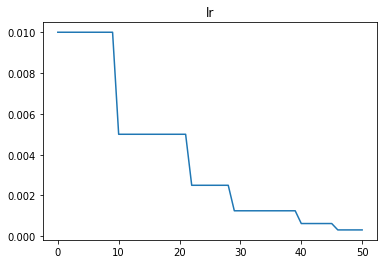

In [ ]:
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

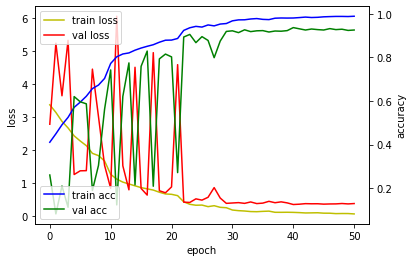

In [ ]:
# 결과 보고를 위한 Loss, Accuracy 출력
# 0.0025부터 급속히 학습 안정화

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history['loss'],'y',label='train loss')
loss_ax.plot(history['val_loss'],'r',label='val loss')
acc_ax.plot(history['accuracy'],'b',label='train acc')
acc_ax.plot(history['val_accuracy'],'g',label='val acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

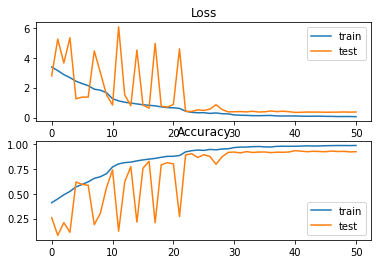

In [ ]:
# 그림이 알아보기 힘들어 Loss, Accuracy로 구분하여 다시 그래프 출력

from matplotlib import pyplot

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history['loss'], label='train')
pyplot.plot(history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history['accuracy'], label='train')
pyplot.plot(history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

##### valid set 폴더 만들기

In [ ]:
class_list = os.listdir('/content/drive/MyDrive/데이터셋2/데이터셋')                              #데이터가 들어있는 폴더 지정 

In [ ]:
origin = '/content/drive/MyDrive/데이터셋'
copy = '/content/drive/MyDrive/validtest'                                               #복사할 폴더 위치 지정

if not os.path.isdir(copy):
  os.makedirs(copy)

In [ ]:
for label in class_list:
  path = f'{copy}/{label}'
  if not os.path.isdir(path):
    os.makedirs(path)

In [ ]:
os.chdir("/content/drive/MyDrive/데이터셋2/데이터셋")                               # 데이터가 있는 폴더로 위치 조정 필요 

In [ ]:
path_list = test_df['path']

for path in path_list:
    path_ = path.strip('.')

    if not os.path.exists(copy+path_):
      shutil.copy(path, copy + path_)

##### 모델별 valid set 기반 f1_score 산출

In [ ]:
def run_eval(model, loader):     
    preds = []
    labels = []
    for img, label in loader:
        y_prob = model.predict(img)
        y_pred = np.argmax(y_prob, axis=1)

        preds.append(y_pred)
        labels.append(label)
    
    y_pred = np.concatenate(preds, axis=0)
    y_test = np.concatenate(labels, axis=0)
    result = classification_report(y_test, y_pred, output_dict=True)

    return pd.DataFrame(result)


def freeze(model):
    for layer in model.layers:
        layer.trainable = False
        
    return model


def check_across_seeds(accs, f1s, result_df, num_classes=20):
    accs = np.array(accs)
    f1s = np.array(f1s)
    
    assert np.all(np.abs(accs[1:] - accs[:1]) < 1e-1) and np.all(np.abs(f1s[1:] - f1s[:1]) < 1e-1), "test results are not compatible \n{}\n{}".format(accs, f1s)

    print("*** CLASSWISE RESULT ***")
    cwise_result = result_df.loc[['f1-score', 'recall', 'support'], [str(i) for i in range(num_classes)]]
    cwise_result = cwise_result.rename(index={'f1-score' : 'f1', 'recall' : 'acc', 'support' : 'support'})
    print(cwise_result)
    
    print("\n*** AVG RESULT ***")
    avg_result = pd.Series({'f1' : result_df.loc['f1-score', 'macro avg'], 'acc' : result_df['accuracy'].values[0]})
    print(avg_result)
    
    
def f1_scores(DATA_dir, CKPT_path):
    DATA_DIR = DATA_dir
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_VAR = (0.229 ** 2, 0.224 ** 2, 0.225 ** 2)
    
    global CLF
  
    CKPT_PATH = CKPT_path
    
    """ if saved with model.save_weights() """
    CLF.load_weights(CKPT_PATH).expect_partial()

    


    CLF = freeze(CLF)
    CLF.compile(metrics=['accuracy'])
    
    SEEDS = [0, 5, 10]
    ACC_LIST = []
    F1_LIST = []
    for seed in SEEDS:
        tf.random.set_seed(seed)
        
        loader = tf.keras.preprocessing.image_dataset_from_directory(
            directory=DATA_DIR,
            image_size=(256, 256),
            batch_size=128,
            shuffle=False
            )
        
        augmentation_layer = tf.keras.Sequential([
            tf.keras.layers.CenterCrop(224,224),
            tf.keras.layers.Rescaling(1./255),         
        ])
        loader = loader.map(lambda x,y: (augmentation_layer(x),y))
        
        RESULT_DF = run_eval(CLF, loader)
        ACC_LIST.append(RESULT_DF['accuracy'].values[0])
        F1_LIST.append(RESULT_DF.loc['f1-score', 'macro avg'])

    check_across_seeds(ACC_LIST, F1_LIST, RESULT_DF)   

In [ ]:
CLF = get_classifier_base()

f1_scores('/content/drive/MyDrive/validtest', '/content/drive/MyDrive/base_model.ckpt-20221104T043630Z-001/base_model.ckpt')  # 경로지정 필요

Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 20ms/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 18ms/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 29ms/step
*** CLASSWISE RESULT ***
                 0          1          2          3          4          5  \
f1        0.632768   0.512821   0.723005   0.650602   0.507042   0.542373   
acc       0.708861   0.400000   0.793814   0.675000   0.409091   0.432432   
support  79.000000  25.000000  97.000000  40.000000  44.000000  37.000000   

                 6          7          8          9         10         11  \
f1        0.642857   0.551724   0.578947   0.540541   0.680000   0.786517   
acc       0.642857   0.521739   0.500000   0.571429   0.731183   0.760870   
support  98.000000  46.000000  22.000000  35.000000  93.000000  46.000000   

                12         13         14         15         16          17 

In [ ]:
CLF = get_classifier1()


f1_scores('/content/drive/MyDrive/validtest', '/content/drive/MyDrive/데이터셋/vgg19/best_model.ckpt')

Found 1064 files belonging to 20 classes.
2/2 [==============================] - 3s 2s/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 128ms/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 127ms/step
*** CLASSWISE RESULT ***
                 0          1          2         3          4          5  \
f1        0.912500   0.916667   0.921466   0.84507   0.790698   0.864865   
acc       0.924051   0.880000   0.907216   0.75000   0.772727   0.864865   
support  79.000000  25.000000  97.000000  40.00000  44.000000  37.000000   

                 6          7          8          9         10         11  \
f1        0.927835   0.831461   0.883721   0.864865   0.950820   0.947368   
acc       0.918367   0.804348   0.863636   0.914286   0.935484   0.978261   
support  98.000000  46.000000  22.000000  35.000000  93.000000  46.000000   

                12         13         14         15         16          17  \
f

In [ ]:
CLF = get_classifier2()

f1_scores('/content/drive/MyDrive/validtest', '/content/drive/MyDrive/데이터셋/best_model_modified_batch_64_9_1.ckpt')

Found 1064 files belonging to 20 classes.
2/2 [==============================] - 2s 718ms/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 101ms/step
Found 1064 files belonging to 20 classes.
2/2 [==============================] - 0s 101ms/step
*** CLASSWISE RESULT ***
                 0          1          2          3          4          5  \
f1        0.975309   0.958333   0.989796   0.987654   0.977273   0.945946   
acc       1.000000   0.920000   1.000000   1.000000   0.977273   0.945946   
support  79.000000  25.000000  97.000000  40.000000  44.000000  37.000000   

                 6          7          8          9         10    11  \
f1        0.968421   0.967742   0.954545   0.916667   0.972678   1.0   
acc       0.938776   0.978261   0.954545   0.942857   0.956989   1.0   
support  98.000000  46.000000  22.000000  35.000000  93.000000  46.0   

                12         13         14         15         16          17  \
f1        0.96

### 7. 교차 타당화 (10-Fold Cross Validation) - 시간 부족으로 진행하지 못함




#### 참고자료

적정 폴드 수를 산정하는 방식 (참고)

https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html

Sensitivity Analysis 기반 적정 폴드 수 산정

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

K가 크거나 작을 때 발생하는 문제 (Trade Off)

Kuhn, M., & Johnson, K. (2013). Applied predictive modeling (Vol. 26, p. 13). New York: Springer.



#### 분석 절차

In [ ]:
finaldata = pd.read_csv("under sample2501000_final.csv")

idg = ImageDataGenerator(rescale = 1./255)
idg2 = ImageDataGenerator(horizontal_flip = True, 
                          width_shift_range = .3, height_shift_range = .3, 
                          rotation_range = 30.0, zoom_range = 0.2, 
                          fill_mode = 'nearest', rescale = 1./255)
sgd = optimizers.SGD(learning_rate = 0.005, decay = 1e-6, momentum = 0.9, nesterov = True)

warnings.filterwarnings('ignore')

In [ ]:
from model_f import get_classifier

validation_accuracy = []
validation_loss = []
val_acc = 0

fold_var = 1

# 적정 폴드 수 계산하는 참고자료에 기반하여 n_splits 결정
# 범주별 데이터 수가 다르기 때문에 반드시 Stratifeid K-Fold를 활용해야 함.
skf = StratifiedKFold(n_splits = 10, random_state = None, shuffle = False)
for train_index, test_index in skf.split(finaldata, finaldata['label']):
 
    train_set = finaldata.iloc[train_index]
    valid_set = finaldata.iloc[test_index]

    train_data_generator = idg2.flow_from_dataframe(train_set, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode = 'categorical', batch_size = 64, shuffle = True)
    valid_data_generator = idg.flow_from_dataframe(valid_set, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode = 'categorical', batch_size = 64, shuffle = True)
    
    counter = Counter(train_data_generator.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

    model = get_classifier(num_classes = 20) 
    model.compile(loss = 'categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

    filepath = './models/best_model_cross_validated_' + str(fold_var) + ".ckpt"
    
    earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = .2, patience = 5, verbose = 1, mode = 'min')
    ModelCheckpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only = True, verbose = 1)
    
    callbacks_list = [reduceLR, ModelCheckpoint, earlystopping]

    history = model.fit(
    train_data_generator,
    epochs = 50,
    steps_per_epoch = len(train_data_generator),
    batch_size = 64,
    validation_data = valid_data_generator,
    use_multiprocessing = True,
    workers = 8,
    callbacks = callbacks_list,
    class_weight = class_weights
    )

    model.load_weights(filepath)
    model_path = "./" + str(fold_var) + ".h5"
    model.save(model_path)

    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names, results))

    validation_accuracy.append(results['acc'])
    validation_loss.append(results['loss'])
    
    tf.keras.backend.clear_session()

    fold_var += 1
    
    val_acc += results['acc'] / 5

print(val_acc)
